In [2]:
!pip install opendatasets

     |████████████████████████████████| 181 kB 917 kB/s eta 0:00:01
     |████████████████████████████████| 78 kB 1.8 MB/s eta 0:00:01
     |████████████████████████████████| 98 kB 1.9 MB/s eta 0:00:01
     |████████████████████████████████| 78 kB 1.9 MB/s eta 0:00:01
     |████████████████████████████████| 311 kB 1.7 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [7]:
!pip install pandas

     |████████████████████████████████| 11.3 MB 1.8 MB/s eta 0:00:01    |████████▊                       | 3.1 MB 1.2 MB/s eta 0:00:08
     |████████████████████████████████| 15.7 MB 5.1 MB/s eta 0:00:01     |██████████████████████▋         | 11.1 MB 9.1 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [27]:
!pip install matplotlib

     |████████████████████████████████| 11.2 MB 9.7 MB/s eta 0:00:01
     |████████████████████████████████| 3.4 MB 8.4 MB/s eta 0:00:01
     |████████████████████████████████| 1.1 MB 3.2 MB/s eta 0:00:01
     |████████████████████████████████| 965 kB 5.7 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [8]:
import opendatasets as od
import pandas as pd
import time
from functools import reduce
from pathlib import Path

In [10]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import to_json,col
from pyspark.sql.types import *
from os.path import abspath

spark = SparkSession\
        .builder\
        .appName("pyspark-notebook")\
        .master("spark://spark-master:7077")\
        .config("spark.executor.memory", "512m")\
        .config("hive.metastore.uris", "thrift://hive-metastore:9083")\
        .config("spark.sql.warehouse.dir", "/user/hive/warehouse")\
        .enableHiveSupport()\
        .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")

25/05/27 15:02:26 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [9]:
dataset_path = Path('dgomonov/new-york-city-airbnb-open-data', 'AB_NYC_2019.csv')
if not dataset_path.is_file():
    od.download('https://www.kaggle.com/datasets/dgomonov/new-york-city-airbnb-open-data')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:

  anastaiiaaleks


Your Kaggle Key:

  ································


Dataset URL: https://www.kaggle.com/datasets/dgomonov/new-york-city-airbnb-open-data


100%|██████████| 2.44M/2.44M [00:00<00:00, 57.9MB/s]

In [11]:
data = spark.read.csv(path="new-york-city-airbnb-open-data/AB_NYC_2019.csv", sep=",", header=True)

In [12]:
data.count()

49079

In [13]:
df = pd.read_csv('new-york-city-airbnb-open-data/AB_NYC_2019.csv')

In [20]:
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [21]:
df.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,4.889500e+04,4.889500e+04,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,38843.000000,48895.000000,48895.000000
mean,1.901714e+07,6.762001e+07,40.728949,-73.952170,152.720687,7.029962,23.274466,1.373221,7.143982,112.781327
std,1.098311e+07,7.861097e+07,0.054530,0.046157,240.154170,20.510550,44.550582,1.680442,32.952519,131.622289
min,2.539000e+03,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,9.471945e+06,7.822033e+06,40.690100,-73.983070,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,1.967728e+07,3.079382e+07,40.723070,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,2.915218e+07,1.074344e+08,40.763115,-73.936275,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000
max,3.648724e+07,2.743213e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


In [22]:
# Проверяем наличие NaN в колонке 'price'
print("Количество пропущенных значений в 'price':", df['price'].isna().sum())

Количество пропущенных значений в 'price': 0


In [24]:
# Проверяем тип данных (должен быть числовой)
print("Тип данных в 'price':", df['price'].dtype)

Тип данных в 'price': int64


In [25]:
# Удаляем выбросы
# Рассчитываем квартили
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)

# IQR — межквартильное расстояние
IQR = Q3 - Q1

# Применяем фильтр: оставляем значения между Q1 и Q3
df_filtered = df[(df['price'] >= Q1) & (df['price'] <= Q3)]

print(f"Фильтрация по квартилям: Q1 = {Q1}, Q3 = {Q3}")
print(f"Исходный размер: {len(df)}, после фильтрации: {len(df_filtered)}")

Фильтрация по квартилям: Q1 = 69.0, Q3 = 175.0
Исходный размер: 48895, после фильтрации: 24719


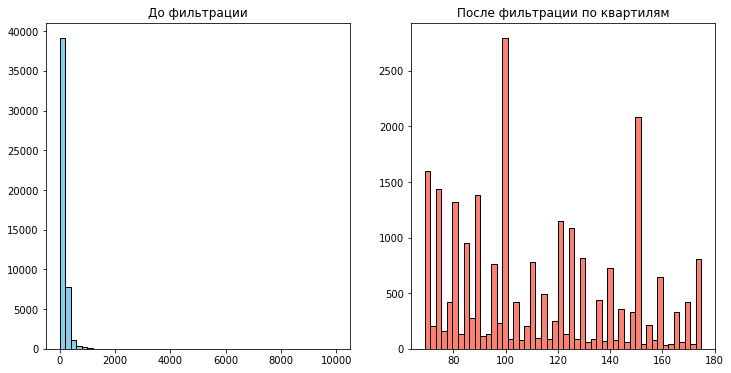

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(df['price'], bins=50, color='skyblue', edgecolor='black')
plt.title('До фильтрации')

plt.subplot(1, 2, 2)
plt.hist(df_filtered['price'], bins=50, color='salmon', edgecolor='black')
plt.title('После фильтрации по квартилям')

plt.show()

In [30]:
df_filtered[['price']].to_csv('cleaned_prices.csv', index=False)

### Работа в HIVE

Перенос готового csv-файла в контейнер namenode
```bash
user$ docker cp jupyterlab:/tmp/cleaned_prices.csv namenode:/tmp/
    >>> copying between containers is not supported
user$ docker cp jupyterlab:/tmp/cleaned_prices.csv ./cleaned_prices.csv
    >>> Successfully copied 90.6kB to /mnt/c/Users/chiffka/apache-spark-docker/docker/cleaned_prices.csv
user$ docker cp ./cleaned_prices.csv namenode:/tmp/
    >>>Successfully copied 90.6kB to namenode:/tmp/
```

Работа в hive: создание БД, таблицы.

```bash
user$ docker exec -it hive-server beeline -u jdbc:hive2://localhost:10000

0: jdbc:hive2://localhost:10000> create database if not exists pricing;
No rows affected (0.461 seconds)
0: jdbc:hive2://localhost:10000> use pricing;
No rows affected (0.029 seconds)
0: jdbc:hive2://localhost:10000> create external table prices (
. . . . . . . . . . . . . . . .> price double
. . . . . . . . . . . . . . . .> )
. . . . . . . . . . . . . . . .> location '/user/hive/pricing/';
No rows affected (0.206 seconds)
```

Вычисление среднего
```bash
0: jdbc:hive2://localhost:10000> select avg(price) as mean_price from prices;
```

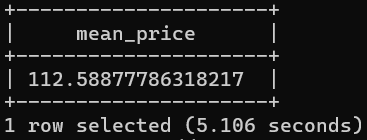

Вычисление дисперсии
```bash
0: jdbc:hive2://localhost:10000> select avg(price * price) - avg(price) as variance from prices;
```

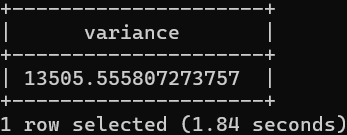

### Работа со Spark.SQL

In [32]:
data = spark.read.csv(path="cleaned_prices.csv", sep=",", header=True)

In [33]:
data.write.saveAsTable('hive_table')

In [34]:
ndf= spark.sql("""
select * from hive_table
""")

In [52]:
ndf.show(5)

+-----+
|price|
+-----+
|  149|
|  150|
|   89|
|   80|
|   79|
+-----+
only showing top 5 rows



In [38]:
ndf_mean = spark.sql("""
select avg(price) as mean_price from hive_table""")

In [39]:
ndf_mean.show()

+------------------+
|        mean_price|
+------------------+
|112.58877786318217|
+------------------+



In [40]:
ndf_var = spark.sql("""
select
avg(price * price) - avg(price) as variance_price
from hive_table""")

In [41]:
ndf_var.show()

+------------------+
|    variance_price|
+------------------+
|13505.555807273757|
+------------------+



### MapReducer

In [42]:
import os

if os.path.exists('cleaned_prices.csv'):
    print('Нашли файл')
else:
    print('Файл не найден')

Нашли файл


In [43]:
%%writefile mapper.py

#! /usr/bin/env python3

import sys

for line in sys.stdin:
    line = line.strip()
    if not line:
        continue
    try:
        price = float(line)
        print(f'mean\t{price}')
        print(f'variance\t{price}\t{price * price}')
    except ValueError:
        continue

Writing mapper.py


In [44]:
%%writefile reducer.py

#!/usr/bin/env python3

import sys

current_key = None
count = 0
sum_price = 0
sum_sq = 0

for line in sys.stdin:
    line = line.strip()
    if not line:
        continue
    
    parts = line.split('\t')
    key = parts[0]
    
    if current_key is None:
        current_key = key
        
    if key != current_key:
        if current_key == "mean":
            mean = sum_price / count
            print(f'mean\t{mean}')
        elif current_key == "variance":
            mean = sum_price / count
            mean_sq = sum_sq / count
            var = mean_sq - mean * mean
            print(f'variance\t{var}')
            
        current_key = key
        count = 0
        sum_price = 0
        sum_sq = 0
        
    if key == "mean":
        price = float(parts[1])
        count += 1
        sum_price += price
    elif key == "variance":
        price = float(parts[1])
        sq = float(parts[2])
        count += 1
        sum_price += price
        sum_sq += sq
        
if current_key == "mean":
    mean = sum_price / count
    print(f'mean\t{mean}')
elif current_key == "variance":
    mean = sum_price / count
    mean_sq = sum_sq / count
    var = mean_sq - mean * mean
    print(f'variance\t{var}')

Writing reducer.py


In [46]:
!chmod +x mapper.py reducer.py

In [47]:
!ls -l mapper.py reducer.py

-rwxrwxrwx 1 1000 1000  281 May 28 07:15 mapper.py
-rwxrwxrwx 1 1000 1000 1225 May 28 07:15 reducer.py


In [48]:
!cat cleaned_prices.csv | python mapper.py | sort | python reducer.py

mean	112.58877786318217
variance	941.911684411958


### Сравнение методов

| Метод | Mean | Variance |
|-------|------|----------|
| Hive  |  112.58877786318217 |  13505.555807273757 |
| Spark SQL | 112.58877786318217 | 13505.555807273757 |
| MapReduce | 112.58877786318217 | 941.911684411958 |